In [1]:
import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, str(base_dir))
import earthnet_minicuber as emc

import matplotlib.pyplot as plt
import numpy as np
from shapely import Polygon
import geopandas as gpd
import contextily as cx

# Normal minicuber query

In [2]:
specs = {
    "lon_lat": (262620.0, 5126060.0), #lon-lat center pixel
    "xy_shape": (128, 128), # width, height of cutout around center pixel
    "resolution": 10, # in meters.. will use this on a local UTM grid..
    "time_interval": "2022-01-01/2022-01-31",
    "final_epsg": 32632,
    "providers": [
        {
            "name": "s2",
            "kwargs": {"bands": ["AOT", "B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "WVP"], "brdf_correction": True, "cloud_mask": True, "data_source": "planetary_computer"}
        }
        ]
}

In [3]:
mc = emc.load_minicube(specs, compute = True, verbose=True)

Loading Sentinel2 for 2022-01-01/2022-01-31


In [7]:
mc

<xarray.Dataset> Size: 6MB
Dimensions:              (time: 12, lat: 128, lon: 128)
Coordinates:
  * time                 (time) datetime64[ns] 96B 2022-01-02 ... 2022-01-29
  * lon                  (lon) float64 1kB 2.626e+05 2.626e+05 ... 2.639e+05
  * lat                  (lat) float64 1kB 5.126e+06 5.126e+06 ... 5.125e+06
Data variables: (12/21)
    s2_AOT               (time, lat, lon) uint16 393kB 157 157 157 ... 93 93 93
    s2_B01               (time, lat, lon) uint16 393kB 1995 1995 ... 660 660
    s2_B02               (time, lat, lon) uint16 393kB 2295 2295 ... 294 341
    s2_B03               (time, lat, lon) uint16 393kB 2307 2307 ... 357 326
    s2_B04               (time, lat, lon) uint16 393kB 2199 2199 ... 346 332
    s2_B05               (time, lat, lon) uint16 393kB 2178 2178 ... 647 609
    ...                   ...
    s2_mask              (time, lat, lon) uint16 393kB 1 1 1 1 1 1 ... 0 0 0 0 0
    product_uri          (time) <U65 3kB 'S2B_MSIL2A_20220102T104339_N0300_R0...
    mean_solar_zenith    (time) float32 48B 70.25 70.5 69.79 ... 66.19 66.19
    mean_solar_azimuth   (time) float32 48B 70.25 70.5 69.79 ... 66.19 66.19
    mean_sensor_zenith   (time) float32 48B 9.003 4.771 9.002 ... 9.014 4.805
    mean_sensor_azimuth  (time) float32 48B 9.003 4.771 9.002 ... 9.014 4.805
Attributes:
    history:                  Created by Sélène Ledain on 2024-05-26 17:51:20...
    source:                   Microsoft Planetary Computer
    coordinates:              EPSG:32632. Coordinates are upper left corners ...
    missing data fill value:  65535
    processing:               Baseline correction, cloud masking, BRDF correc...

# Breakdown data querying

In [4]:
# From minicuber class

from pyproj import Transformer
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info

def bbox(lon_lat, xy_shape, resolution):

    utm_epsg = int(query_utm_crs_info(
        datum_name="WGS 84",
        area_of_interest=AreaOfInterest(lon_lat[0], lon_lat[1], lon_lat[0], lon_lat[1])
    )[0].code)

    transformer = Transformer.from_crs(4326, utm_epsg, always_xy=True)

    x_center, y_center = transformer.transform(*lon_lat)

    nx, ny = xy_shape
    
    x_left, x_right = x_center - resolution * (nx//2), x_center + resolution * (nx//2)

    y_top, y_bottom = y_center + resolution * (ny//2), y_center - resolution * (ny//2)

    return transformer.transform_bounds(x_left, y_bottom, x_right, y_top, direction = 'INVERSE') # left, bottom, right, top

def padded_bbox(bbox, xy_shape):
    left, bottom, right, top = bbox
    lat_extra = (top - bottom) / xy_shape[0] * 6
    lon_extra = (right - left) / xy_shape[1] * 6
    return left - lon_extra, bottom - lat_extra, right + lon_extra, top + lat_extra

def lon_lat_grid(bbox, xy_shape):
    nx, ny = xy_shape
    lon_left, lat_bottom, lon_right, lat_top = bbox

    lon_grid = np.linspace(lon_left, lon_right, nx)
    lat_grid = np.linspace(lat_top, lat_bottom, ny)

    return lon_grid, lat_grid

In [5]:
# From sentinel2.py

import os
import pystac_client
from pystac_client.stac_api_io import StacApiIO

URL = 'https://planetarycomputer.microsoft.com/api/stac/v1'

stac_api_io = StacApiIO()
stac_api_io.session.verify = os.environ.get('CURL_CA_BUNDLE')
catalog = pystac_client.Client.open(URL,stac_io=stac_api_io)

In [6]:
# From minicuber.load_data and sentinel2

lon_lat = (5.929193380543842, 46.24109841038423) #lon-lat
xy_shape = (128, 128)
resolution = 10
time_interval = "2022-01-01/2022-01-31"

bbox_query = bbox(lon_lat=lon_lat, xy_shape=xy_shape, resolution=resolution)
padded_bbox_query = padded_bbox(bbox_query, xy_shape)
lon_grid, lat_grid = lon_lat_grid(bbox_query, xy_shape)

search = catalog.search(
        bbox = padded_bbox_query,
        collections=["sentinel-2-l2a"],
        datetime=time_interval
) # returns a ItermSearch object (search object of STAC API)

In [122]:
# Padded bbox in 32632

patch_x = 262620
patch_y = 5126060
bbox_32632 = Polygon([(patch_x, patch_y), (patch_x+1280, patch_y), (patch_x+1280, patch_y-1280), (patch_x, patch_y-1280), (patch_x, patch_y)])

left, bottom, right, top = gpd.GeoDataFrame(geometry=[bbox_32632], crs=32632).total_bounds
lat_extra = (top - bottom) / 128 * 6
lon_extra = (right - left) / 128 * 6
print(lat_extra, lon_extra, 'in meters')


# Padded bbox in minicuber

minx, miny, maxx, maxy = padded_bbox_query
padded_bbox_poly = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
padded_bbox_gdf = gpd.GeoDataFrame(geometry=[padded_bbox_poly], crs=4326).to_crs(32632)
left_pad, bottom_pad, right_pad, top_pad = padded_bbox_gdf.total_bounds

minx, miny, maxx, maxy = bbox_query
bbox_poly = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_poly], crs=4326).to_crs(32632)
left, bottom, right, top = bbox_gdf.total_bounds

print(left_pad-left, top_pad-top, 'in meters')

# Padded bbox in minicuber

minx, miny, maxx, maxy = padded_bbox_query
padded_bbox_poly = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
padded_bbox_gdf = gpd.GeoDataFrame(geometry=[padded_bbox_poly], crs=4326)
left_pad, bottom_pad, right_pad, top_pad = padded_bbox_gdf.total_bounds

minx, miny, maxx, maxy = bbox_query
bbox_poly = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_poly], crs=4326)
left, bottom, right, top = bbox_gdf.total_bounds
print(left_pad-left, top_pad-top, 'in degrees')

60.0 60.0 in meters
-64.55351746123051 64.54672755394131 in meters
-0.0008059635349821903 0.0005592217718444203 in degrees


Text(0.5, 1.0, '32632 reproj to 4326(green) vs query box(green)')

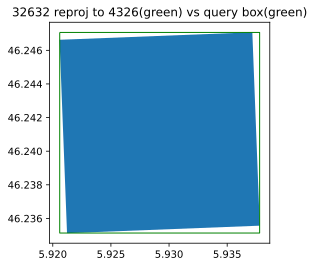

In [120]:
# Take grid cell, create bbox in 32632 then reproject to 4326
# Compare to bbox created by minicuber

patch_x = 262620
patch_y = 5126060
bbox_32632 = Polygon([(patch_x, patch_y), (patch_x+1280, patch_y), (patch_x+1280, patch_y-1280), (patch_x, patch_y-1280), (patch_x, patch_y)])
bbox_4326 = gpd.GeoDataFrame(geometry=[bbox_32632], crs=32632).to_crs(4326)

minx, miny, maxx, maxy = bbox_query
bbox = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])

fig, axs = plt.subplots(1,1,figsize=(4,4))
bbox_4326.plot(ax=axs)
gpd.GeoDataFrame(geometry=[bbox], crs=4326).plot(ax=axs, edgecolor='g', facecolor='none')
axs.set_title('32632 reproj to 4326(green) vs query box(green)')

Text(0.5, 1.0, 'Specs(blue), data returned(pink), padded(red)')

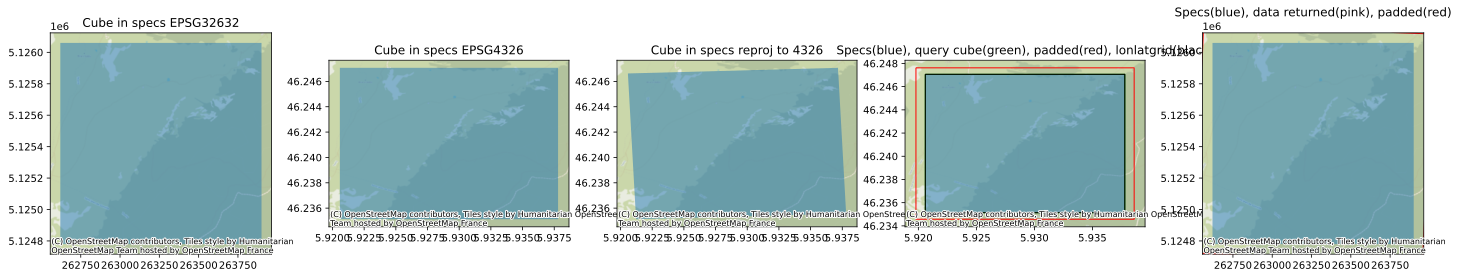

In [10]:
# Plot the cube asked (in EPSG 32632 and then projected to 4326)
# Plot the cube created my minicuber when creating a bbox out of center coords and shape
# Plot the extent of the returned data

from shapely import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

minx, miny, maxx, maxy = (262620.0, 5124780.0, 263900.0, 5126060.0)
bbox1 = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
gdf_bbox1 = gpd.GeoDataFrame(geometry=[bbox1], crs="EPSG:32632")

minx, miny, maxx, maxy = (5.9205818499027885, 46.23512370020329, 5.937803185685051, 46.247072808909316)
bbox2 = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
gdf_bbox2 = gpd.GeoDataFrame(geometry=[bbox2], crs="EPSG:4326")

fig, axs = plt.subplots(1,5,figsize=(25,4))

# Plot the cube passed in specs
gdf_bbox1.plot(ax=axs[0], alpha=0.5)
cx.add_basemap(axs[0], crs=gdf_bbox1.crs)
axs[0].set_title("Cube in specs EPSG32632")

gdf_bbox2.plot(ax=axs[1], alpha=0.5)
cx.add_basemap(axs[1], crs=gdf_bbox2.crs)
axs[1].set_title("Cube in specs EPSG4326")

gdf_bbox1.to_crs(4326).plot(ax=axs[2], alpha=0.5)
cx.add_basemap(axs[2], crs=4326)
axs[2].set_title("Cube in specs reproj to 4326")

# Plot the bbox created by minicuber and compare to expected
gdf_bbox2.plot(ax=axs[3], alpha=0.5)

minx, miny, maxx, maxy = bbox_query
bbox = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
gpd.GeoDataFrame(geometry=[bbox], crs=4326).plot(ax=axs[3], edgecolor='g', facecolor='none')

minx, miny, maxx, maxy = padded_bbox_query
bbox = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
gpd.GeoDataFrame(geometry=[bbox], crs=4326).plot(ax=axs[3], edgecolor='r', facecolor='none')

minx, miny, maxx, maxy = lon_grid[0], lat_grid[-1], lon_grid[-1], lat_grid[0]
bbox = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
gpd.GeoDataFrame(geometry=[bbox], crs=4326).plot(ax=axs[3], edgecolor='black', facecolor='none')

cx.add_basemap(axs[3], crs=4326)
axs[3].set_title("Specs(blue), query cube(green), padded(red), lonlatgrid(black)")


# Plot the returned data
gdf_bbox1.plot(ax=axs[4], alpha=0.5)
cx.add_basemap(axs[4], crs=gdf_bbox1.crs)

minx, miny, maxx, maxy = (mc['lon'].min().item(), mc['lat'].min().item(), mc['lon'].max().item(), mc['lat'].max().item())
data_bbox = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
gpd.GeoDataFrame(geometry=[data_bbox], crs=32632).plot(ax=axs[4], edgecolor='pink', facecolor='none')

minx, miny, maxx, maxy = padded_bbox_query
bbox = Polygon([(minx, maxy), (maxx, maxy), (maxx, miny), (minx, miny), (minx, maxy)])
gpd.GeoDataFrame(geometry=[bbox], crs=4326).to_crs(32632).plot(ax=axs[4], edgecolor='r', facecolor='none')

axs[4].set_title("Specs(blue), data returned(pink), padded(red)")

In [7]:
# From sentinel2

import planetary_computer as pc 
import stackstac
import rasterio
from rasterio import RasterioIOError

items_s2 = pc.sign(search) # will perform serach and return ItemCollection that is signed. GeoJSON FeatureCollection whose features are all STAC Items

metadata = items_s2.to_dict()['features'][0]["properties"]
epsg = metadata["proj:epsg"]

gdal_session = stackstac.DEFAULT_GDAL_ENV.updated(always=dict(session=rasterio.session.AWSSession(aws_unsigned = True, endpoint_url = None)))
bands = ["AOT", "B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "WVP"]
stack = stackstac.stack(items_s2, epsg = epsg, assets = bands, dtype = "float32", properties = ["s2:product_uri", "s2:mean_solar_zenith", "s2:mean_solar_azimuth"], band_coords = False, bounds_latlon = padded_bbox_query, xy_coords = 'center', chunksize = 2048,errors_as_nodata=(RasterioIOError('.*'), ), gdal_env=gdal_session)

In [ ]:
bands = stack.band.values
stack["band"] = [f"s2_{b}" for b in stack.band.values]

stack = stack.to_dataset("band")

In [ ]:
import tempfile
import urllib
import uuid
from xml.dom import minidom
from datetime import datetime
import numpy as np

def parse_MTD_TL(in_file):
    """
    Parses the MTD_TL.xml metadata file provided by ESA.This metadata
    XML is usually placed in the GRANULE subfolder of a ESA-derived
    S2 product and named 'MTD_TL.xml'.

    The 'MTD_TL.xml' is available for both processing levels (i.e.,
    L1C and L2A). The function is able to handle both processing
    sources and returns some entries available in L2A processing level,
    only, as None type objects.

    The function extracts the most important metadata from the XML and
    returns a dict with those extracted entries.

    :param in_file:
        filepath of the scene metadata xml 8MTD_TL.xml)
    :return metadata:
        dict with extracted metadata entries
    """
    # parse the xml file into a minidom object
    xmldoc = minidom.parse(in_file)

    # now, the values of some relevant tags can be extracted:
    metadata = dict()

    # get tile ID of L2A product and its corresponding L1C counterpart
    tile_id_xml = xmldoc.getElementsByTagName("TILE_ID")
    # adaption to older Sen2Cor version
    check_l1c = True
    if len(tile_id_xml) == 0:
        tile_id_xml = xmldoc.getElementsByTagName("TILE_ID_2A")
        check_l1c = False
    tile_id = tile_id_xml[0].firstChild.nodeValue
    scene_id = tile_id.split(".")[0]
    metadata["SCENE_ID"] = scene_id

    # check if the scene is L1C or L2A
    is_l1c = False
    if check_l1c:
        try:
            l1c_tile_id_xml = xmldoc.getElementsByTagName("L1C_TILE_ID")
            l1c_tile_id = l1c_tile_id_xml[0].firstChild.nodeValue
            l1c_tile_id = l1c_tile_id.split(".")[0]
            metadata["L1C_TILE_ID"] = l1c_tile_id
        except Exception:
            logger.info(f"{scene_id} is L1C processing level")
            is_l1c = True

    # sensing time (acquisition time)
    sensing_time_xml = xmldoc.getElementsByTagName("SENSING_TIME")
    sensing_time = sensing_time_xml[0].firstChild.nodeValue
    metadata["SENSING_TIME"] = sensing_time
    metadata["SENSING_DATE"] = datetime.strptime(
        sensing_time.split("T")[0], "%Y-%m-%d"
    ).date()

    # number of rows and columns for each resolution -> 10, 20, 60 meters
    nrows_xml = xmldoc.getElementsByTagName("NROWS")
    ncols_xml = xmldoc.getElementsByTagName("NCOLS")
    resolutions = ["_10m", "_20m", "_60m"]
    # order: 10, 20, 60 meters spatial resolution
    for ii in range(3):
        nrows = nrows_xml[ii].firstChild.nodeValue
        ncols = ncols_xml[ii].firstChild.nodeValue
        metadata["NROWS" + resolutions[ii]] = int(nrows)
        metadata["NCOLS" + resolutions[ii]] = int(ncols)

    # EPSG-code
    epsg_xml = xmldoc.getElementsByTagName("HORIZONTAL_CS_CODE")
    epsg = epsg_xml[0].firstChild.nodeValue
    metadata["EPSG"] = int(epsg.split(":")[1])

    # Upper Left Corner coordinates -> is the same for all three resolutions
    ulx_xml = xmldoc.getElementsByTagName("ULX")
    uly_xml = xmldoc.getElementsByTagName("ULY")
    ulx = ulx_xml[0].firstChild.nodeValue
    uly = uly_xml[0].firstChild.nodeValue
    metadata["ULX"] = float(ulx)
    metadata["ULY"] = float(uly)
    # endfor

    # extract the mean zenith and azimuth angles
    # the sun angles come first followed by the mean angles per band
    zenith_angles = xmldoc.getElementsByTagName("ZENITH_ANGLE")
    metadata["SUN_ZENITH_ANGLE"] = float(zenith_angles[0].firstChild.nodeValue)

    azimuth_angles = xmldoc.getElementsByTagName("AZIMUTH_ANGLE")
    metadata["SUN_AZIMUTH_ANGLE"] = float(azimuth_angles[0].firstChild.nodeValue)

    # get the mean zenith and azimuth angle over all bands
    sensor_zenith_angles = [float(x.firstChild.nodeValue) for x in zenith_angles[1::]]
    metadata["SENSOR_ZENITH_ANGLE"] = np.mean(np.asarray(sensor_zenith_angles))

    sensor_azimuth_angles = [float(x.firstChild.nodeValue) for x in azimuth_angles[1::]]
    metadata["SENSOR_AZIMUTH_ANGLE"] = np.mean(np.asarray(sensor_azimuth_angles))

    # extract scene relevant data about nodata values, cloud coverage, etc.
    cloudy_xml = xmldoc.getElementsByTagName("CLOUDY_PIXEL_PERCENTAGE")
    cloudy = cloudy_xml[0].firstChild.nodeValue
    metadata["CLOUDY_PIXEL_PERCENTAGE"] = float(cloudy)

    degraded_xml = xmldoc.getElementsByTagName("DEGRADED_MSI_DATA_PERCENTAGE")
    degraded = degraded_xml[0].firstChild.nodeValue
    metadata["DEGRADED_MSI_DATA_PERCENTAGE"] = float(degraded)

    # the other tags are available in L2A processing level, only
    if not is_l1c:
        nodata_xml = xmldoc.getElementsByTagName("NODATA_PIXEL_PERCENTAGE")
        nodata = nodata_xml[0].firstChild.nodeValue
        metadata["NODATA_PIXEL_PERCENTAGE"] = float(nodata)

        darkfeatures_xml = xmldoc.getElementsByTagName("DARK_FEATURES_PERCENTAGE")
        darkfeatures = darkfeatures_xml[0].firstChild.nodeValue
        metadata["DARK_FEATURES_PERCENTAGE"] = float(darkfeatures)

        cs_xml = xmldoc.getElementsByTagName("CLOUD_SHADOW_PERCENTAGE")
        cs = cs_xml[0].firstChild.nodeValue
        metadata["CLOUD_SHADOW_PERCENTAGE"] = float(cs)

        veg_xml = xmldoc.getElementsByTagName("VEGETATION_PERCENTAGE")
        veg = veg_xml[0].firstChild.nodeValue
        metadata["VEGETATION_PERCENTAGE"] = float(veg)

        noveg_xml = xmldoc.getElementsByTagName("NOT_VEGETATED_PERCENTAGE")
        noveg = noveg_xml[0].firstChild.nodeValue
        metadata["NOT_VEGETATED_PERCENTAGE"] = float(noveg)

        water_xml = xmldoc.getElementsByTagName("WATER_PERCENTAGE")
        water = water_xml[0].firstChild.nodeValue
        metadata["WATER_PERCENTAGE"] = float(water)

        unclass_xml = xmldoc.getElementsByTagName("UNCLASSIFIED_PERCENTAGE")
        unclass = unclass_xml[0].firstChild.nodeValue
        metadata["UNCLASSIFIED_PERCENTAGE"] = float(unclass)

        cproba_xml = xmldoc.getElementsByTagName("MEDIUM_PROBA_CLOUDS_PERCENTAGE")
        cproba = cproba_xml[0].firstChild.nodeValue
        metadata["MEDIUM_PROBA_CLOUDS_PERCENTAGE"] = float(cproba)

        hcproba_xml = xmldoc.getElementsByTagName("HIGH_PROBA_CLOUDS_PERCENTAGE")
        hcproba = hcproba_xml[0].firstChild.nodeValue
        metadata["HIGH_PROBA_CLOUDS_PERCENTAGE"] = float(hcproba)

        thcirrus_xml = xmldoc.getElementsByTagName("THIN_CIRRUS_PERCENTAGE")
        thcirrus = thcirrus_xml[0].firstChild.nodeValue
        metadata["THIN_CIRRUS_PERCENTAGE"] = float(thcirrus)

        snowice_xml = xmldoc.getElementsByTagName("SNOW_ICE_PERCENTAGE")
        snowice = snowice_xml[0].firstChild.nodeValue
        metadata["SNOW_ICE_PERCENTAGE"] = float(snowice)

    return metadata



def angles_from_mspc(url):
    """
    Extract viewing angles from MS Planetary Computer
    metadata XML (this is a work-around until STAC provides the angles
    directly)

    :param url:
        URL to the metadata XML file
    :returns:
        extracted angles as dictionary
    """
    response = urllib.request.urlopen(pc.sign_url(url)).read()
    temp_file = os.path.join(tempfile.gettempdir(), f'{uuid.uuid4()}.xml')
    with open(temp_file, 'wb') as dst:
        dst.write(response)
    metadata = parse_MTD_TL(in_file=temp_file)
    # get sensor zenith and azimuth angle
    sensor_angles = ['SENSOR_ZENITH_ANGLE', 'SENSOR_AZIMUTH_ANGLE', 'SUN_ZENITH_ANGLE', 'SUN_AZIMUTH_ANGLE']
    sensor_angle_dict = {
        k: v for k, v in metadata.items() if k in sensor_angles}
    return sensor_angle_dict

In [ ]:
# Faster method to add the sensor angles

items_dict = {item.id: item for item in items_s2}
ordered_items = [items_dict[itemid] for itemid in stack.id.values]
sensor_zenith = []
for item in ordered_items:
    item = item.to_dict()
    granule_metadata_href = item["assets"]["granule-metadata"]["href"].split('xml')[0] + 'xml'
    sensor_angles = angles_from_mspc(granule_metadata_href)
    sensor_zenith.append(sensor_angles["SENSOR_ZENITH_ANGLE"])

In [ ]:
# Add sensor angles using product uri

# Move the extra coordinates to variables, as the time variable will be change to date
stack = stack.reset_coords('s2:product_uri').rename({'s2:product_uri': 'product_uri'})
stack = stack.reset_coords('s2:mean_solar_zenith').rename({'s2:mean_solar_zenith': 'mean_solar_zenith'})
stack = stack.reset_coords('s2:mean_solar_azimuth').rename({'s2:mean_solar_azimuth': 'mean_solar_azimuth'})

In [ ]:
# View items -> they are whole tiles, at different dates


import geopandas as gpd
from shapely.geometry import Polygon

df = gpd.GeoDataFrame.from_features(items_s2.to_dict(), crs="epsg:4326")
df.head()

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx

fig, ax = plt.subplots(figsize=(8,8))
df.plot(ax=ax, edgecolor='red', facecolor='none')
ax.set_xlim((df.total_bounds[0]-0.5, df.total_bounds[2]+0.5))
ax.set_ylim((df.total_bounds[1]-0.1, df.total_bounds[3]+0.1))
ctx.add_basemap(ax, crs=df.crs)

## Trying download approach

In [ ]:
# Figuring out the tile geometry for tile 32TMT

import planetary_computer as pc 
import stackstac
import rasterio
from rasterio import RasterioIOError
import geopandas as gpd
import os
import pystac_client
from pystac_client.stac_api_io import StacApiIO

# Setup client

URL = 'https://planetarycomputer.microsoft.com/api/stac/v1'

stac_api_io = StacApiIO()
stac_api_io.session.verify = os.environ.get('CURL_CA_BUNDLE')
catalog = pystac_client.Client.open(URL,stac_io=stac_api_io)

# Define what we search

lon_lat = (8.5417, 47.3796) # Zurich, in 32TMT
xy_shape = (128, 128)
resolution = 10
time_interval = "2021-07-01/2021-07-31"

bbox_query = bbox(lon_lat=lon_lat, xy_shape=xy_shape, resolution=resolution)
padded_bbox_query = padded_bbox(bbox_query, xy_shape)

search = catalog.search(
        bbox = padded_bbox_query,
        collections=["sentinel-2-l2a"],
        datetime=time_interval
) # retruns a ItermSearch object (search object of STAC API)


# Query data

items_s2 = pc.sign(search) # will perform serach and return ItemCollection that is signed. GeoJSON FeatureCollection whose features are all STAC Items

metadata = items_s2.to_dict()['features'][0]["properties"]
epsg = metadata["proj:epsg"]

gdal_session = stackstac.DEFAULT_GDAL_ENV.updated(always=dict(session=rasterio.session.AWSSession(aws_unsigned = True, endpoint_url = None)))
bands = ["AOT", "B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "WVP"]
stack = stackstac.stack(items_s2, epsg = epsg, assets = bands, dtype = "float32", properties = ["sentinel:product_id"], band_coords = False, bounds_latlon = padded_bbox_query, xy_coords = 'center', chunksize = 2048,errors_as_nodata=(RasterioIOError('.*'), ), gdal_env=gdal_session)


# View data
df = gpd.GeoDataFrame.from_features(items_s2.to_dict(), crs="epsg:4326")

print(df.geometry.values[0])

In [ ]:
# Query data

specs = {
    "lon_lat": (df.geometry.values[0].centroid.x, df.geometry.values[0].centroid.y), # center pixel (lon-lat)
    "xy_shape": (1024, 1024), # width, height of cutout around center pixel
    "resolution": 10, # in meters.. will use this on a local UTM grid..
    "time_interval": "2021-01-01/2021-01-31",
    "providers": [
        {
            "name": "s2",
            "kwargs": {"bands": ["AOT", "B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "WVP"], "best_orbit_filter": False, "five_daily_filter": False, "brdf_correction": True, "cloud_mask": False, "aws_bucket": "planetary_computer"}
        }
        ]
}

mc = emc.load_minicube(specs, compute = True)

In [ ]:
# Compare bbox that is queried and extent of data returned

from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd


bbox_query = bbox(lon_lat=specs["lon_lat"], xy_shape=specs["xy_shape"], resolution=specs["resolution"])
padded_bbox_query = padded_bbox(bbox_query, specs["xy_shape"])


# Create a Polygon from the coordinates
polygon_bbox = Polygon([
    (bbox_query[0], bbox_query[1]),
    (bbox_query[2], bbox_query[1]),
    (bbox_query[2], bbox_query[3]),
    (bbox_query[0], bbox_query[3]),
    (bbox_query[0], bbox_query[1])
])

polygon_padded_bbox = Polygon([
    (padded_bbox_query[0], padded_bbox_query[1]),
    (padded_bbox_query[2], padded_bbox_query[1]),
    (padded_bbox_query[2], padded_bbox_query[3]),
    (padded_bbox_query[0], padded_bbox_query[3]),
    (padded_bbox_query[0], padded_bbox_query[1])
])

# Create a GeoDataFrame with the Polygon
gdf_bbox = gpd.GeoDataFrame({'geometry': [polygon_bbox]}, crs='EPSG:4326')
gdf_padded_bbox = gpd.GeoDataFrame({'geometry': [polygon_padded_bbox]}, crs='EPSG:4326')

# Get extent of the data
point_ul = (mc['lon'].values[0], mc['lat'].values[0])
point_ur = (mc['lon'].values[-1], mc['lat'].values[0])

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(6, 6))
gdf_bbox.plot(ax=ax, alpha=0.5, edgecolor='blue', facecolor='none')
gdf_padded_bbox.plot(ax=ax, alpha=0.5, edgecolor='red', facecolor='none')
plt.plot(point_ul[0], point_ul[1], 'ko', markersize=3)  
plt.plot(point_ur[0], point_ur[1], 'ko', markersize=3)  


# Add contextily background
ctx.add_basemap(ax, crs=gdf_bbox.crs)

plt.show()